# Imports

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from typing import List, Callable, Tuple, Any
from wandb.wandb_run import Run
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, metrics, cv

import attr
import pandas as pd
import gc
import os
import wandb
import nest_asyncio
import logging
import sys
import numpy as np

nest_asyncio.apply()

while "freqtrade" not in os.listdir():
    os.chdir("..")
    if "freqtrade" in os.listdir():
        nest_asyncio.apply()
        logger = logging.getLogger("freqtrade.ml")
        handler = logging.StreamHandler(stream=sys.stdout)
        handler.setFormatter(logging.Formatter("%(name)s - %(message)s"))
        logger.addHandler(handler)
        logger.setLevel(logging.DEBUG)
    
from freqtrade.ml.lightning import LightningModule, LightningConfig
from freqtrade.ml.trainer import TradingTrainer
from freqtrade.ml.container import LightningContainer
from freqtrade.ml import loader, lightning_utils

from freqtrade.nbtools.helper import free_mem
from freqtrade.nbtools.pairs import PAIRS_HIGHCAP_NONSTABLE

container = None

if container is not None:
    print("Deleting container")
    free_mem(container)
    
gc.collect()

0

# Lightning Module

In [2]:
MINI_DATA = True  # True if used for testing purposes

attr.s(repr=False)
class CatBoost(LightningModule):
    """ Template for LightningModule """
        
    def on_configure(self) -> LightningConfig:
        
        # This datetime can be replaced with datetime.now()
        now = datetime(2021, 8, 20)
        
        # Lighting Configuration
        config = LightningConfig(
            
            # Basic info
            name        = "15n30-catboost_intentional",
            timeframe   = "15m",
            exchange    = "binance",
            
            # Train and validation datetime
            trainval_start  = now - timedelta(days=365 * 5),
            trainval_end    = now - timedelta(days=61),
            
            # Backtest Optimization datetime
            opt_start = now - timedelta(days=60),
            opt_end   = now - timedelta(days=31),
            
            # Unbiased Backtest datetime
            test_start = now - timedelta(days=30),
            test_end   = now,
            
            # Num training epochs
            num_training_epochs = 100,
        )
        
        # Optional custom config attributes
        config.add_custom("num_future_candles", 2)
        config.add_custom("num_classification_classes", 5)
        config.add_custom("hardware", "CPU")
        config.add_custom("learning_rate", 0.002)
        
        return config
        
    def on_get_data_paths(self, cwd: Path, timeframe: str, exchange: str) -> List[Path]:
        """ Where your data is stored
        """
        path_data_exchange = cwd.parent / "mount" / "data" / exchange
        maximum_data = 999 if not MINI_DATA else 5
        
        return [
            datapath
            for datapath in list(path_data_exchange.glob(f"*-{timeframe}.json"))
            if datapath.name.split("-")[0].replace("_", "/")
            in PAIRS_HIGHCAP_NONSTABLE[:maximum_data]
        ]
    
    def on_add_features(self, df_onepair: pd.DataFrame) -> pd.DataFrame:
        """ On Add Features will be used in inference
        """
        future_price = df_onepair['close'].shift(-self.config.num_future_candles)
        df_onepair['ml_next_close'] = (future_price - df_onepair['close']) / df_onepair['close']
        return df_onepair
    
    def on_add_labels(self, df_onepair: pd.DataFrame) -> pd.DataFrame:
        """ Define the labels
        """
        future_price = df_onepair['close'].shift(-self.config.num_future_candles)
        ml_label = (future_price - df_onepair['close']) / df_onepair['close']
        df_onepair[self.config.column_y] = pd.qcut(ml_label, self.config.num_classification_classes, labels=False)
        return df_onepair
    
    def on_final_processing(self, df_allpairs: pd.DataFrame) -> Tuple[Any, Any, Any, Any]:
        """ Define the data to X_train, X_val, y_train, y_val
        """
        val_split_date = pd.to_datetime(self.config.trainval_end - timedelta(days=60), utc=True, infer_datetime_format=True)
        
        train = df_allpairs[df_allpairs["date"] < val_split_date]
        val = df_allpairs[df_allpairs["date"] >= val_split_date]
        
        X_train = train[self.config.columns_x]
        X_val = val[self.config.columns_x]
        y_train = train[self.config.column_y]
        y_val = val[self.config.column_y]
        
        return X_train, X_val, y_train, y_val
    
    def on_define_model(self, run: Run, X_train, X_val, y_train, y_val) -> Any:
        """ Define your model!
        """
        return CatBoostClassifier(
            custom_loss=[metrics.Accuracy()],
            iterations=self.config.num_training_epochs, 
            task_type=self.config.hardware,
            learning_rate=self.config.learning_rate,
         )
    
    def on_start_training(self, run: Run, X_train, X_val, y_train, y_val):
        """ Training / model fit code
        """
        print("Start Training...")
        self.model: CatBoostClassifier
        self.model.fit(
            X_train, y_train,
            eval_set=(X_val, y_val),
            plot=True,
            verbose=25,
        )
        print("Accuracy: %.2f" % self.model.score(X_val, y_val))
    
    def on_predict(self, df_input_onepair: pd.DataFrame) -> pd.DataFrame:
        """ Inference, used in freqtrade
        """
        df_input_np = df_input_onepair.to_numpy()
        preds = self.model.predict_proba(df_input_np)
        df_preds = pd.DataFrame(preds)
        return df_preds
    
    def on_training_step(self, run: Run, data: dict):
        raise NotImplementedError()


module = CatBoost()

# Dataset EDA Before Training

In [3]:
df_: pd.DataFrame = lightning_utils.get_dataset_df(module)
dates = df_["date"]
df_ = df_[module.config.columns_x + [module.config.column_y]]
df_.tail()

Load and preprocess data:   0%|          | 0/5 [00:00<?, ?it/s]

,ml_next_close,ml_label
123338,-0.003629,1.0
123339,-0.004145,1.0
123340,0.000650,2.0
123341,-0.000260,2.0
123342,-0.006045,0.0


In [4]:
def dataframe_statistics(df_: pd.DataFrame):
    # Detect nan, infinity, and too large values in dataset
    print("N rows na:", str(df_.shape[0] - df_.dropna().shape[0]))
    print("N rows inf:", str(df_.shape[0] - df_.replace([np.inf, -np.inf], np.nan).dropna().shape[0]))
    print("Cols na:", str(df_.columns[df_.isna().any()].tolist()))
    print("Cols inf:", str(list(df_.columns.to_series()[np.isinf(df_).any()])))

    # Detect columns with irregular datatypes
    supported_datatypes = ["float32"]
    print("Irregular (col, dtypes):", str([(it, df_[it].dtype) for it in df_.columns if df_[it].dtype not in supported_datatypes]))

    # Dataset statistics
    print("Dataset Length: %s" % len(df_))
    print("Date Min: %s" % dates.min())
    print("Date Max: %s" % dates.max())
    
dataframe_statistics(df_)

N rows na: 0
N rows inf: 0
Cols na: []
Cols inf: []
Irregular (col, dtypes): []
Dataset Length: 558699
Date Min: 2017-08-17 04:00:00+00:00
Date Max: 2021-06-19 23:00:00+00:00


<AxesSubplot:>

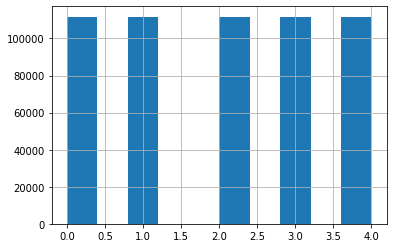

In [5]:
df_["ml_label"].hist()

In [8]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558699 entries, 0 to 123342
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ml_next_close  558699 non-null  float32
 1   ml_label       558699 non-null  float32
dtypes: float32(2)
memory usage: 8.5 MB


In [7]:
# Unload dataset after EDA to save memory
free_mem(df_)

# [-Start Training-]

In [9]:
with wandb.init(project=module.config.name) as run:
    trainer = TradingTrainer()
    container = trainer.fit(module, run, True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jliberooo (use `wandb login --relogin` to force relogin)


freqtrade.ml.trainer - Validating model using mini training...


Load and preprocess data:   0%|          | 0/1 [00:00<?, ?it/s]

Start Training...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.6015000	test: 1.6014842	best: 1.6014842 (0)	total: 191ms	remaining: 1.72s
9:	learn: 1.5337239	test: 1.5335041	best: 1.5335041 (9)	total: 457ms	remaining: 0us

bestTest = 1.533504108
bestIteration = 9

Accuracy: 1.00
freqtrade.ml.container - Not dropping X columns in predict because it doesn't exist in predict columns
freqtrade.ml.container - Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']

PASSED: The model passed the validation test!
freqtrade.ml.trainer - Validate model OK!


Load and preprocess data:   0%|          | 0/5 [00:00<?, ?it/s]

Start Training...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.6028460	test: 1.6025409	best: 1.6025409 (0)	total: 122ms	remaining: 12.1s
25:	learn: 1.4556983	test: 1.4490812	best: 1.4490812 (25)	total: 2.97s	remaining: 8.46s
50:	learn: 1.3348622	test: 1.3234887	best: 1.3234887 (50)	total: 5.82s	remaining: 5.59s
75:	learn: 1.2330793	test: 1.2180198	best: 1.2180198 (75)	total: 8.68s	remaining: 2.74s
99:	learn: 1.1489356	test: 1.1308014	best: 1.1308014 (99)	total: 11.4s	remaining: 0us

bestTest = 1.130801379
bestIteration = 99

Accuracy: 0.94


wandb: Adding directory to artifact (c:\CS\Python\crypto-collection\freqtrade\superft\.temp\lightning_15n30-catboost_intentional_2021-09-02_21-45-01)... Done. 0.0s


# Predictions EDA

In [5]:
# Validate prediction function by simulate inserting freqtrade data into predict function
df_val_preds = trainer.validate_predict(container)
df_val_preds

freqtrade.ml.container - Not dropping X columns in predict because it doesn't exist in predict columns


INFO:freqtrade.ml.container:Not dropping X columns in predict because it doesn't exist in predict columns


freqtrade.ml.container - Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']


INFO:freqtrade.ml.container:Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']



Dataset: Binance BTC/USDT 15m iloc[-10000:] (Freqtrade Regularized)


DF WITH PREDICTIONS INFO
----------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 131026 to 141025
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   date    10000 non-null  datetime64[ns, UTC]
 1   open    10000 non-null  float64            
 2   high    10000 non-null  float64            
 3   low     10000 non-null  float64            
 4   close   10000 non-null  float64            
 5   volume  10000 non-null  float64            
 6   ml_0    9998 non-null   float64            
 7   ml_1    9998 non-null   float64            
 8   ml_2    9998 non-null   float64            
 9   ml_3    9998 non-null   float64            
 10  ml_4    9998 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(10)
memory usage: 937.5 KB
None


DF Original
----------
                            date      open  

,date,open,high,low,close,volume,ml_0,ml_1,ml_2,ml_3,ml_4
131026,2021-05-13 00:30:00+00:00,49711.83,50630.00,49578.94,49896.61,5110.913916,0.163629,0.163629,0.163628,0.175082,0.334032
131027,2021-05-13 00:45:00+00:00,49896.15,50324.72,49581.44,49666.99,2389.969100,0.163499,0.163499,0.163498,0.173767,0.335738
131028,2021-05-13 01:00:00+00:00,49661.12,50600.00,49305.43,50191.47,3869.211034,0.333124,0.176003,0.163624,0.163624,0.163624
131029,2021-05-13 01:15:00+00:00,50191.47,50437.86,49972.44,50324.12,2755.398561,0.165340,0.165340,0.167072,0.269613,0.232636
131030,2021-05-13 01:30:00+00:00,50314.99,50374.48,49665.94,49889.82,2116.566505,0.163499,0.163499,0.163498,0.173767,0.335738
...,...,...,...,...,...,...,...,...,...,...,...
141021,2021-08-25 03:15:00+00:00,48135.89,48274.85,48117.73,48250.65,211.447645,0.333124,0.176003,0.163624,0.163624,0.163624
141022,2021-08-25 03:30:00+00:00,48250.65,48275.00,48132.05,48191.09,194.839454,0.163916,0.189612,0.316306,0.166248,0.163918
141023,2021-08-25 03:45:00+00:00,48191.08,48248.23,47965.00,47975.93,344.786940,0.163456,0.169008,0.336713,0.167368,0.163455
141024,2021-08-25 04:00:00+00:00,47975.93,48245.00,47940.02,48155.56,275.930495,NaN,NaN,NaN,NaN,NaN


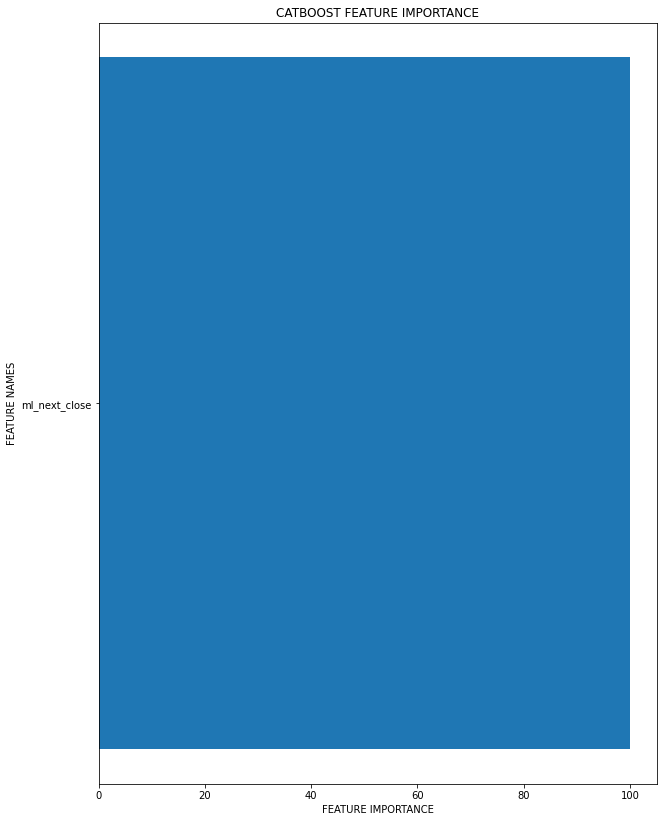

In [11]:
def plot_feature_importance(importance,names,model_type):
    import matplotlib.pyplot as plt
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,14))
    #Plot Searborn bar chart
    plt.barh(width=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(container.module.model.get_feature_importance(), container.config.columns_x, 'CATBOOST')

# Simple Statistics & Backtesting

In [20]:
df_dataset = container._load_df_allpairs()
df_dataset["real_close"] = (df_dataset["close"].shift(-2) - df_dataset["close"]) / df_dataset["close"]
df_dataset.loc[df_dataset["ml_label"] == 4].tail()

,date,open,high,low,close,volume,pair,ml_next_close,ml_label,real_close
109655,2021-06-19 13:45:00+00:00,0.7888,0.7895,0.7863,0.7891,2827095.500,XRP/USDT,0.004055,4.0,0.004055
109656,2021-06-19 14:00:00+00:00,0.7892,0.7930,0.7890,0.7903,2622069.750,XRP/USDT,0.006706,4.0,0.006706
109657,2021-06-19 14:15:00+00:00,0.7903,0.7931,0.7903,0.7923,1890240.125,XRP/USDT,0.006185,4.0,0.006185
109675,2021-06-19 18:45:00+00:00,0.7790,0.7823,0.7789,0.7802,2696326.500,XRP/USDT,0.005255,4.0,0.005255
109676,2021-06-19 19:00:00+00:00,0.7804,0.7810,0.7790,0.7806,2119528.500,XRP/USDT,0.004996,4.0,0.004996


In [21]:
preds = container.module.model.predict_proba(df_dataset[container.config.columns_x])
preds = pd.DataFrame(preds)
preds.columns = [f"ml_{i}" for i in range(5)]
df_with_preds = pd.concat([df_dataset.reset_index(drop=True), preds], axis=1)
df_with_preds.tail()

,date,open,high,low,close,volume,pair,ml_next_close,ml_label,real_close,ml_0,ml_1,ml_2,ml_3,ml_4
519648,2021-06-19 22:00:00+00:00,0.7839,0.7839,0.7769,0.7786,3941359.25,XRP/USDT,-0.007963,0.0,-0.007963,0.334792,0.174676,0.163510,0.163511,0.163511
519649,2021-06-19 22:15:00+00:00,0.7785,0.7790,0.7763,0.7784,2686081.00,XRP/USDT,-0.015673,0.0,-0.015673,0.334792,0.174676,0.163510,0.163511,0.163511
519650,2021-06-19 22:30:00+00:00,0.7786,0.7788,0.7705,0.7724,3667547.00,XRP/USDT,-0.011264,0.0,-0.011264,0.334792,0.174676,0.163510,0.163511,0.163511
519651,2021-06-19 22:45:00+00:00,0.7725,0.7725,0.7606,0.7662,8737225.00,XRP/USDT,-0.003524,1.0,NaN,0.181662,0.320236,0.170614,0.163744,0.163744
519652,2021-06-19 23:00:00+00:00,0.7661,0.7663,0.7574,0.7637,8876527.00,XRP/USDT,-0.003797,1.0,NaN,0.210817,0.287778,0.170293,0.165555,0.165556


In [22]:
df_with_preds["argmax_ml"] = df_with_preds[[f"ml_{x}"for x in range(5)]].idxmax(axis=1)
df_with_preds.loc[(df_with_preds["argmax_ml"] == "ml_4")].tail()

,date,open,high,low,close,volume,pair,ml_next_close,ml_label,real_close,ml_0,ml_1,ml_2,ml_3,ml_4,argmax_ml
519615,2021-06-19 13:45:00+00:00,0.7888,0.7895,0.7863,0.7891,2827095.500,XRP/USDT,0.004055,4.0,0.004055,0.165495,0.165495,0.166198,0.232047,0.270766,ml_4
519616,2021-06-19 14:00:00+00:00,0.7892,0.7930,0.7890,0.7903,2622069.750,XRP/USDT,0.006706,4.0,0.006706,0.163523,0.163523,0.163523,0.174000,0.335431,ml_4
519617,2021-06-19 14:15:00+00:00,0.7903,0.7931,0.7903,0.7923,1890240.125,XRP/USDT,0.006185,4.0,0.006185,0.163533,0.163533,0.163533,0.174289,0.335112,ml_4
519635,2021-06-19 18:45:00+00:00,0.7790,0.7823,0.7789,0.7802,2696326.500,XRP/USDT,0.005255,4.0,0.005255,0.163741,0.163741,0.163741,0.178718,0.330058,ml_4
519636,2021-06-19 19:00:00+00:00,0.7804,0.7810,0.7790,0.7806,2119528.500,XRP/USDT,0.004996,4.0,0.004996,0.163899,0.163899,0.163899,0.185367,0.322936,ml_4


In [14]:
df_val_preds["return"] = (df_val_preds["close"].shift(-2) - df_val_preds["close"]) / df_val_preds["close"]
df_val_preds["argmax_ml"] = df_val_preds[[f"ml_{x}"for x in range(5)]].idxmax(axis=1)
df_val_preds.loc[(df_val_preds["argmax_ml"] == "ml_4")].tail()

,date,open,high,low,close,volume,ml_0,ml_1,ml_2,ml_3,ml_4,return,argmax_ml
140989,2021-08-24 19:15:00+00:00,48137.97,48137.97,47904.61,47954.13,354.085567,0.163629,0.163629,0.163628,0.175082,0.334032,0.006028,ml_4
140990,2021-08-24 19:30:00+00:00,47954.14,48129.99,47906.00,47977.03,284.235138,0.163523,0.163523,0.163523,0.174000,0.335431,0.006838,ml_4
141009,2021-08-25 00:15:00+00:00,47945.22,48123.70,47772.56,47808.54,533.009081,0.164397,0.164397,0.164512,0.196498,0.310196,0.004169,ml_4
141012,2021-08-25 01:00:00+00:00,48007.87,48009.22,47718.16,47813.26,308.271922,0.164045,0.164045,0.164044,0.191169,0.316698,0.004528,ml_4
141013,2021-08-25 01:15:00+00:00,47813.26,47908.69,47739.45,47823.60,367.466489,0.163523,0.163523,0.163523,0.174000,0.335431,0.006954,ml_4


In [15]:
df_val_preds_features = container.add_features(df_val_preds)
df_val_preds_features_preds = container.module.model.predict_proba(df_val_preds_features[container.config.columns_x])
df_val_preds_features_preds = pd.DataFrame(df_val_preds_features_preds)
df_val_preds_features_preds.columns = [f"ml_{i}" for i in range(5)]
df_val_preds_features_with_preds = pd.concat([df_val_preds_features.reset_index(drop=True), df_val_preds_features_preds], axis=1)
df_val_preds_features_with_preds

,date,open,high,low,close,volume,ml_0,ml_1,ml_2,ml_3,ml_4,return,argmax_ml,ml_next_close,ml_0,ml_1,ml_2,ml_3,ml_4
0,2021-05-13 00:30:00+00:00,49711.828125,50630.000000,49578.941406,49896.609375,5110.914062,0.163629,0.163629,0.163628,0.175082,0.334032,0.005909,ml_4,0.005909,0.163629,0.163629,0.163628,0.175082,0.334032
1,2021-05-13 00:45:00+00:00,49896.148438,50324.718750,49581.441406,49666.988281,2389.968994,0.163499,0.163499,0.163498,0.173767,0.335737,0.013231,ml_4,0.013231,0.163499,0.163499,0.163498,0.173767,0.335738
2,2021-05-13 01:00:00+00:00,49661.121094,50600.000000,49305.429688,50191.468750,3869.210938,0.333124,0.176003,0.163624,0.163624,0.163624,-0.006010,ml_0,-0.006010,0.333124,0.176003,0.163624,0.163624,0.163624
3,2021-05-13 01:15:00+00:00,50191.468750,50437.859375,49972.441406,50324.121094,2755.398682,0.165340,0.165340,0.167072,0.269613,0.232636,0.003942,ml_3,0.003942,0.165340,0.165340,0.167072,0.269613,0.232636
4,2021-05-13 01:30:00+00:00,50314.988281,50374.480469,49665.941406,49889.820312,2116.566406,0.163499,0.163499,0.163498,0.173767,0.335737,0.015732,ml_4,0.015732,0.163499,0.163499,0.163498,0.173767,0.335738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,2021-08-25 02:45:00+00:00,48246.570312,48290.199219,48184.410156,48201.230469,258.589996,0.164758,0.165179,0.200350,0.300793,0.168920,0.001025,ml_3,0.001025,0.164758,0.165179,0.200350,0.300793,0.168920
9994,2021-08-25 03:00:00+00:00,48201.238281,48248.238281,48120.000000,48135.898438,270.206665,0.163743,0.163742,0.179276,0.323578,0.169661,0.001147,ml_3,0.001147,0.163743,0.163742,0.179276,0.323578,0.169661
9995,2021-08-25 03:15:00+00:00,48135.890625,48274.851562,48117.730469,48250.648438,211.447647,0.333124,0.176003,0.163624,0.163624,0.163624,-0.005694,ml_0,-0.005694,0.333124,0.176003,0.163624,0.163624,0.163624
9996,2021-08-25 03:30:00+00:00,48250.648438,48275.000000,48132.050781,48191.089844,194.839447,0.163916,0.189612,0.316306,0.166248,0.163918,-0.000737,ml_2,-0.000737,0.163916,0.189612,0.316306,0.166248,0.163918


In [21]:
df_val_preds_features_with_preds["return"] = (df_val_preds_features_with_preds["close"].shift(-2) - df_val_preds_features_with_preds["close"]) / df_val_preds_features_with_preds["close"]
df_val_preds_features_with_preds["argmax_ml"] = df_val_preds_features_with_preds[[f"ml_{x}"for x in range(5)]].idxmax(axis=1)
df_val_preds_features_with_preds.loc[(df_val_preds_features_with_preds["argmax_ml"] == "ml_4")].tail()

,date,open,high,low,close,volume,ml_0,ml_1,ml_2,ml_3,ml_4,return,argmax_ml,ml_next_close,ml_0,ml_1,ml_2,ml_3,ml_4
140989,2021-08-24 19:45:00+00:00,47977.031250,48422.121094,47977.031250,48243.199219,803.434326,0.163629,0.163629,0.163628,0.175082,0.334032,0.001953,ml_4,0.001953,0.163365,0.163365,0.171838,0.331003,0.170429
141009,2021-08-25 00:45:00+00:00,47953.828125,48099.468750,47928.578125,48007.859375,202.902527,0.164397,0.164397,0.164512,0.196498,0.310196,-0.003838,ml_4,-0.003838,0.210817,0.287778,0.170293,0.165555,0.165556
141011,2021-08-25 01:15:00+00:00,47813.261719,47908.691406,47739.449219,47823.601562,367.466492,0.210817,0.287778,0.170293,0.165555,0.165556,0.006954,ml_4,0.006954,0.163523,0.163523,0.163523,0.174000,0.335431
141012,2021-08-25 01:30:00+00:00,47823.589844,48035.980469,47793.269531,48029.738281,274.782837,0.164045,0.164045,0.164044,0.191169,0.316698,0.003722,ml_4,0.003722,0.164095,0.164095,0.168023,0.307615,0.196171
141013,2021-08-25 01:45:00+00:00,48029.738281,48169.558594,47988.269531,48156.171875,509.956879,0.163523,0.163523,0.163523,0.174000,0.335431,-0.001166,ml_4,-0.001166,0.173461,0.326757,0.172629,0.163576,0.163576


In [16]:
model = container.module.model
df = pd.DataFrame({"ml_next_close": [0.005]})
model.predict_proba(df)

array([[0.1638991 , 0.1638991 , 0.16389873, 0.18536746, 0.32293561]])

In [6]:
df.describe()

NameError: name 'df' is not defined